<a href="https://colab.research.google.com/github/DajeanArcila/biblioteca_pandas/blob/main/Revis%C3%A3oClassifica%C3%A7%C3%A3o_chrun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

## Libraries

In [ ]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Visualizar modelos
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    classification_report,
    confusion_matrix,
    roc_auc
)

# Padronizar pandas como output das transformações/modelos
from sklearn import set_config
set_config(transform_output='pandas')

## Load dataset

Vamos utilizar o dataset conhecido como "Census Income" para prever se o salário é maior ou não que 50k USD por ano, disponibilizado pubilicamente em [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/).

Para acessar o dataset e suas informações, [clique aqui](https://archive.ics.uci.edu/dataset/2/adult).

In [ ]:
# Load dataset from the UC Irvine ML Repository
X,y = fetch_openml('adult', as_frame=True, return_X_y=True, version=2, parser='auto')
# Create a single datraframe for it
df = X.join(y)
# Show it :)
display(df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Exploratory Data Analysis (EDA)

## Quality checks

- Tipos de dados corretos?
- Dados duplicados?
- Dados faltantes?

In [ ]:
# Verificar tipos de dados
X.dtypes # X.info()

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
dtype: object

In [ ]:
# Verificar se há dados duplicados
X.duplicated().any()

True

In [ ]:
# Se sim, quantas linhas duplicadas
X.duplicated().sum()

57

In [ ]:
# Há dados duplicados?
X.isna().any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
dtype: bool

In [ ]:
# Há valores faltantes?
X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

In [ ]:
(
    X.isna().sum().to_frame('missing_count')
    .assign(missing_pct = lambda x: x.missing_count / X.shape[0])
    .style
    .format('{:.2%}', subset=['missing_pct'])
)

,missing_count,missing_pct
age,0,0.00%
workclass,2799,5.73%
fnlwgt,0,0.00%
education,0,0.00%
education-num,0,0.00%
marital-status,0,0.00%
occupation,2809,5.75%
relationship,0,0.00%
race,0,0.00%
sex,0,0.00%


→ Há colunas que não fazem sentido / redundantes?

In [ ]:
X[['education','education-num']].value_counts().to_frame('count').sort_index(level=1)

,,count
education,education-num,
Preschool,1,83
1st-4th,2,247
5th-6th,3,509
7th-8th,4,955
9th,5,756
10th,6,1389
11th,7,1812
12th,8,657
HS-grad,9,15784


In [ ]:
y.value_counts(normalize=True)

class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

## Prepare data

In [ ]:
y = y.eq('>50K').astype(int)

# Modeling

In [ ]:
NUMERIC_FEATURES = [
    'age',
    'fnlwgt',
    # 'education-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

CATEGORICAL_FEATURES = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'class'

In [ ]:
# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Pipeline aplica uma sequência de transformações, finalizando com um estimator
# Ele recebe uma lista de tuplas, onde cada tem 2 itens:
# 1 - nome da etapa do pipeline|
# 2 - etapa (transformer ou estimator)

numeric_preprocessor = StandardScaler()

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='ND')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

In [ ]:
categorical_preprocessor.fit_transform(X_train[CATEGORICAL_FEATURES])

,workclass_Federal-gov,workclass_Local-gov,workclass_ND,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
27859,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5654,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3779,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10522,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22461,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
44732,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38158,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# ColumnTransformer especifícia uma lista de tupla, onde cada tupla tem 3 itens:
# 1 - nome do transformador
# 2 - transformador
# 3 - colunas que serão transformadas

preprocessor = ColumnTransformer([
    ('num', numeric_preprocessor, NUMERIC_FEATURES),
    ('cat', categorical_preprocessor, CATEGORICAL_FEATURES)
])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'fnlwgt', 'capital-gain',
                                  'capital-loss', 'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='ND',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race', 'sex',
                                  'native-country'])])

In [ ]:
preprocessor.transform(X_train)

,num__age,num__fnlwgt,num__capital-gain,num__capital-loss,num__hours-per-week,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_ND,cat__workclass_Never-worked,cat__workclass_Private,...,cat__native-country_Portugal,cat__native-country_Puerto-Rico,cat__native-country_Scotland,cat__native-country_South,cat__native-country_Taiwan,cat__native-country_Thailand,cat__native-country_Trinadad&Tobago,cat__native-country_United-States,cat__native-country_Vietnam,cat__native-country_Yugoslavia
27859,0.171771,-1.538807,-0.144508,5.711885,-2.288453,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5654,0.026057,1.225138,-0.144508,-0.220251,-0.276184,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3779,-0.338227,0.671222,-0.144508,-0.220251,0.770196,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10522,1.264622,1.696220,-0.144508,-0.220251,-0.034711,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22461,2.357474,-0.249891,-0.144508,-0.220251,-3.093361,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.192513,4.225793,-0.144508,-0.220251,-0.034711,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
44732,-0.338227,-0.777073,-0.144508,-0.220251,0.770196,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38158,-0.775367,0.572498,-0.144508,-0.220251,-0.034711,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
860,0.536054,-0.880977,-0.144508,-0.220251,-0.034711,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


 ## Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1_000)

clf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', model)
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='ND',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
clf.predict(X_test)

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1'])
cv_results

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'fit_time': array([5.54881668, 6.74465036, 5.81128693, 6.12107539, 7.32366657]),
 'score_time': array([0.195328  , 0.3578012 , 0.19446468, 0.19198036, 0.19471765]),
 'test_accuracy': array([0.8457759 , 0.85503686, 0.85189735, 0.84739285, 0.84957685]),
 'test_balanced_accuracy': array([0.75716026, 0.76983764, 0.76834889, 0.76151731, 0.76083098]),
 'test_recall': array([0.58607022, 0.60532276, 0.60702152, 0.59569649, 0.58946772]),
 'test_precision': array([0.72175732, 0.74546722, 0.73274094, 0.72252747, 0.73413258]),
 'test_f1': array([0.646875  , 0.668125  , 0.66398266, 0.65301055, 0.65389447])}

In [ ]:
pd.DataFrame(cv_results).agg(['mean','std'])

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1
mean,6.309899,0.226858,0.849936,0.763539,0.596716,0.731325,0.657178
std,0.721153,0.073210,0.003666,0.005360,0.009317,0.009732,0.008667


## Compare models

In [ ]:
models = dict(
    dummy = DummyClassifier(),
    lr = LogisticRegression(max_iter=1_000),
    rf = RandomForestClassifier()
)

for model_name, model in models.items():

    print(model_name)

    clf = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('clf', model)
    ])

    cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1'], n_jobs=-1)
    display(pd.DataFrame(cv_results).agg(['mean','std']))
    print()

dummy


,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1
mean,0.478734,0.176501,0.758947,0.5,0.0,0.0,0.0
std,0.106851,0.056880,0.000015,0.0,0.0,0.0,0.0



lr


,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1
mean,5.600742,0.106752,0.849936,0.763539,0.596716,0.731325,0.657178
std,1.740837,0.008172,0.003666,0.005360,0.009317,0.009732,0.008667



rf


,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1
mean,10.658425,0.513787,0.853157,0.771650,0.614270,0.733275,0.668505
std,2.382899,0.088183,0.002692,0.004223,0.007612,0.006501,0.006563


## Tune model

In [ ]:
%%time
clf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clf', RandomForestClassifier())
])

params = {
    'preprocessing__cat__encoder': [
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False),
    ],
    'clf__class_weight': ['balanced', None]
}

grid = GridSearchCV(clf, param_grid=params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 5.48 s, sys: 130 ms, total: 5.61 s
Wall time: 54.4 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='ND',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=Fa...
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__class_weight': ['balanced', None],
                         'preprocessing__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                        unknown_value=-1),
                                                         OneHotEncoder(drop='if_binary',
                                                                       handle_unknown='ignore',
                                                                       sparse_output=False)]},
             scoring='f1', verbose=1)

In [ ]:
grid.best_params_

{'clf__class_weight': None,
 'preprocessing__cat__encoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)}

In [ ]:
grid.best_score_

0.6672913452277682

In [ ]:
tuned_clf = grid.best_estimator_

## Evaluate model

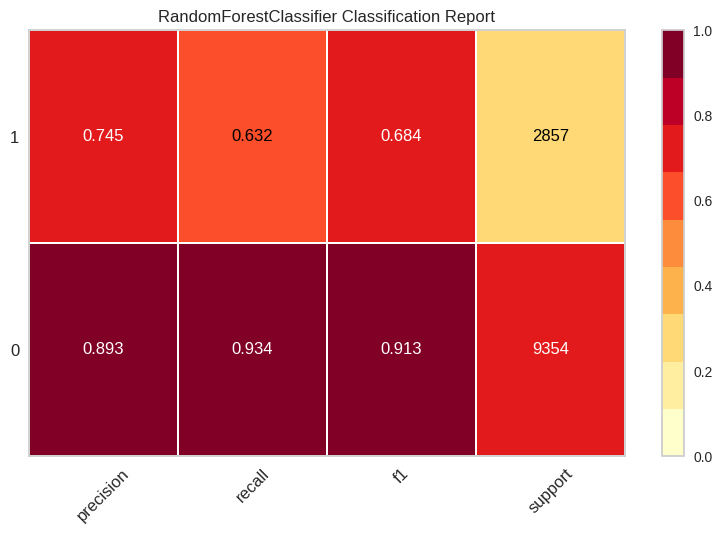

In [ ]:
# Classification Report
classification_report(
    tuned_clf, X_train, y_train, X_test, y_test, classes=tuned_clf.classes_, support=True
);

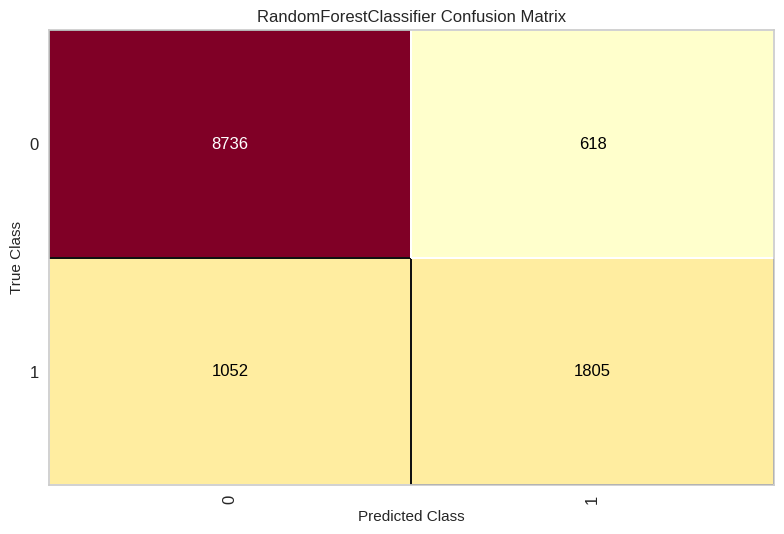

In [ ]:
confusion_matrix(tuned_clf, X_train, y_train, X_test, y_test);

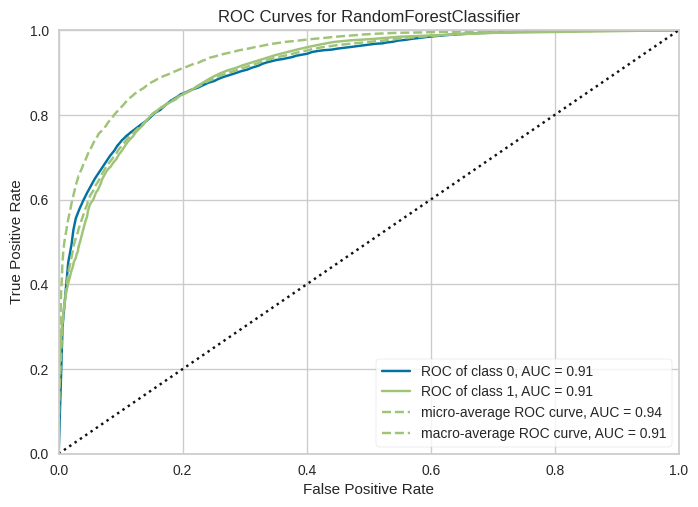

In [ ]:
roc_auc(tuned_clf, X_train, y_train, X_test=X_test, y_test=y_test);

## Interpret model

In [ ]:
preprocessor = tuned_clf['preprocessing']
rf_model = tuned_clf['clf']

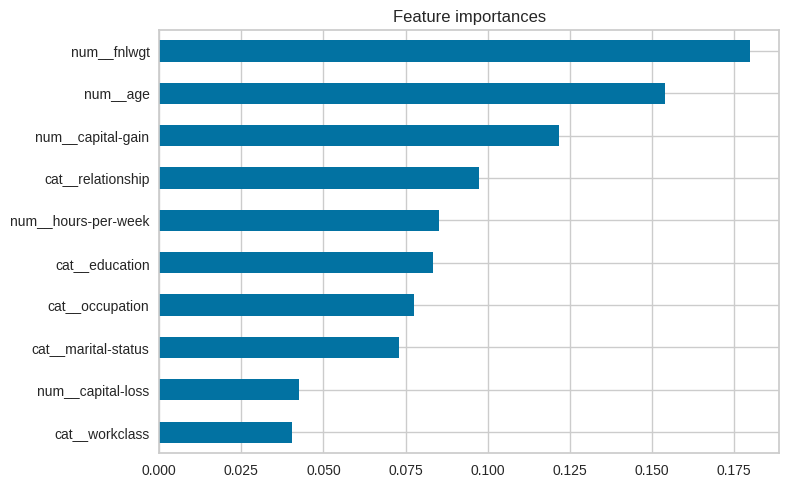

In [ ]:
# Feature importances
pd.Series(
    data=rf_model.feature_importances_,
    index=rf_model.feature_names_in_
).sort_values().tail(10).plot.barh()

plt.title('Feature importances')
plt.show()

In [ ]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)